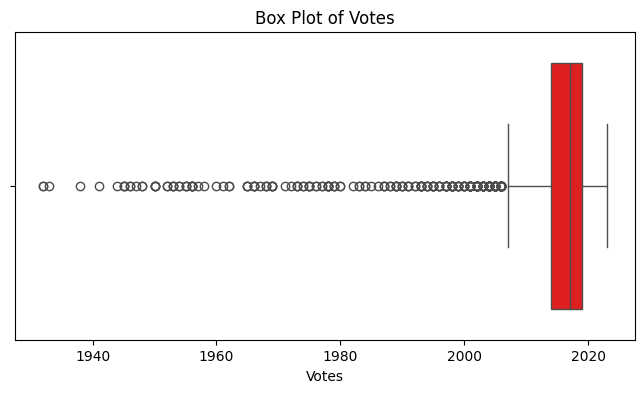

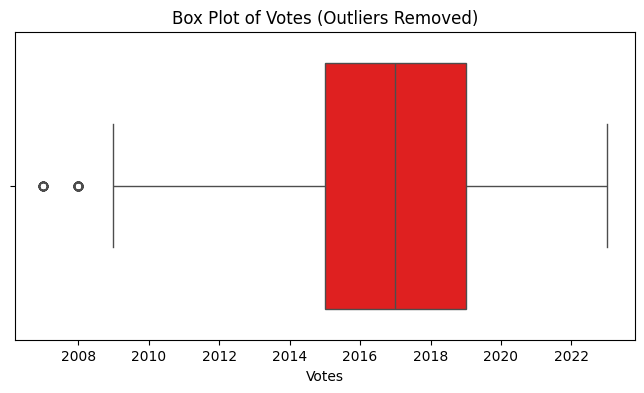

Number of unique genres: 28
['action' 'horror' 'thriller' 'animation' 'adventure' 'drama' 'comedy'
 'crime' 'romance' 'mystery' 'fantasy' 'history' 'sci-fi' 'biography'
 'family' 'documentary' 'music' 'sport' 'short' 'game-show' 'reality-tv'
 'musical' 'war' 'western' 'film-noir' 'unknown' 'talk-show' 'news']

Top 10 Most Frequent Genres:
 genre
drama          2528
comedy         2009
action         1105
documentary     960
crime           849
animation       846
adventure       794
romance         660
thriller        621
mystery         406
Name: count, dtype: int64

Least Frequent Genres:
 genre
music        170
sport        134
unknown       70
war           48
musical       46
game-show     30
talk-show     30
western       24
news          20
film-noir     11
Name: count, dtype: int64

Genre Frequency Distribution:
 genre
drama          2528
comedy         2009
action         1105
documentary     960
crime           849
animation       846
adventure       794
romance         660
t

/var/folders/h5/n23g3h1s3rx_m3_gc9xtb8th0000gn/T/ipykernel_25625/1394837075.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


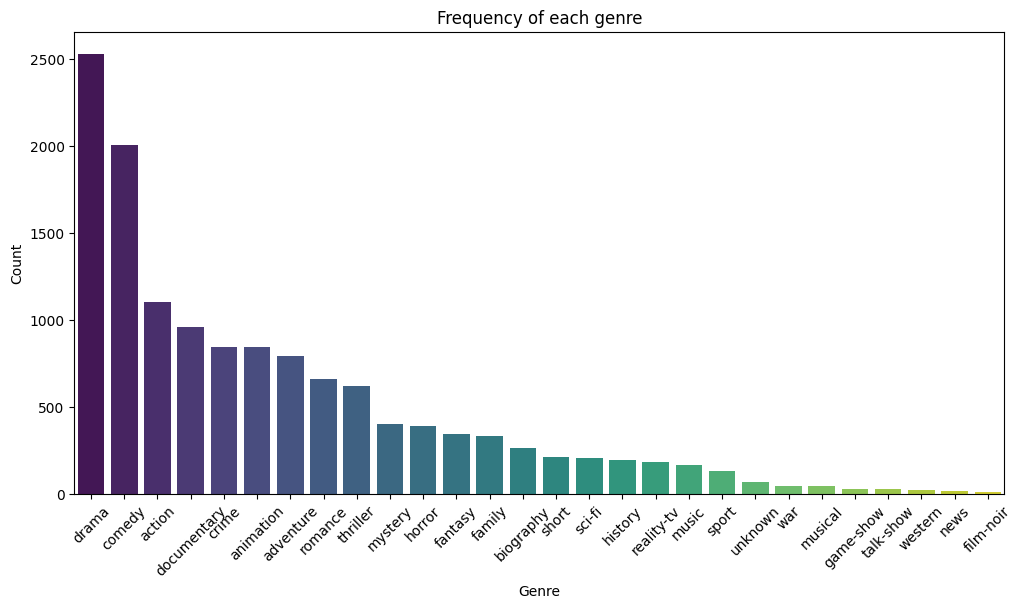

count    5911.000000
mean     2015.363390
std         8.274064
min      1932.000000
25%      2014.000000
50%      2017.000000
75%      2019.000000
max      2023.000000
Name: start_year, dtype: float64


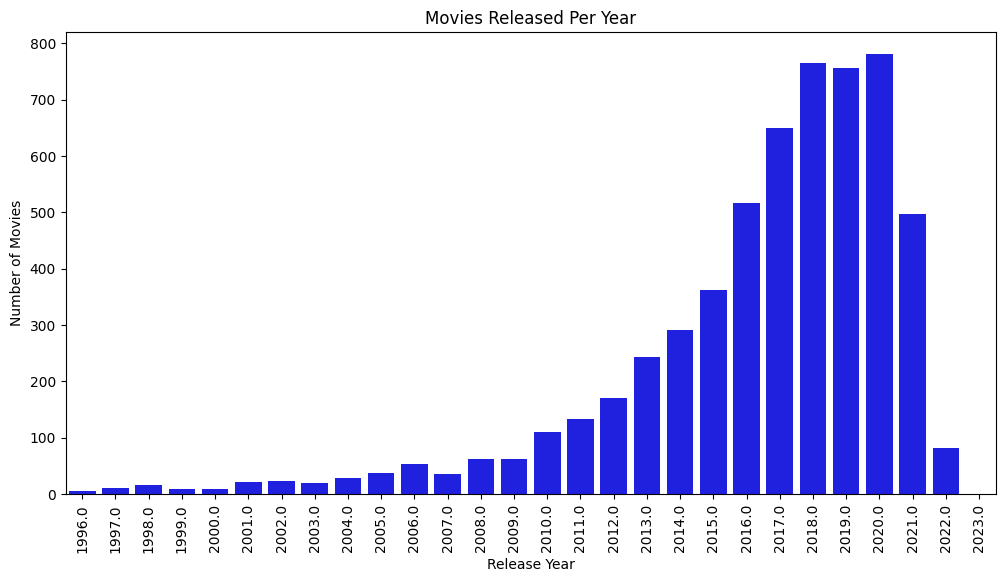

       one-line_length   word_count
count      6422.000000  6422.000000
mean        149.320305    25.462161
std          57.371059    10.091825
min           3.000000     1.000000
25%         116.000000    19.000000
50%         149.000000    25.000000
75%         202.000000    34.000000
max         421.000000    72.000000
count    6422.000000
mean        6.704625
std         0.970174
min         4.100000
25%         6.200000
50%         6.700000
75%         7.300000
max         9.200000
Name: rating, dtype: float64
Movies with the Minimum Rating:
                                       movies  rating
3305               the secrets of emily blair     4.1
3614                          ang probinsyano     4.1
3629                           made in mexico     4.1
3909               million dollar beach house     4.1
3933                                    bucin     4.1
3948                  sí mi amor, la película     4.1
4030                            yummy mummies     4.1
4146           

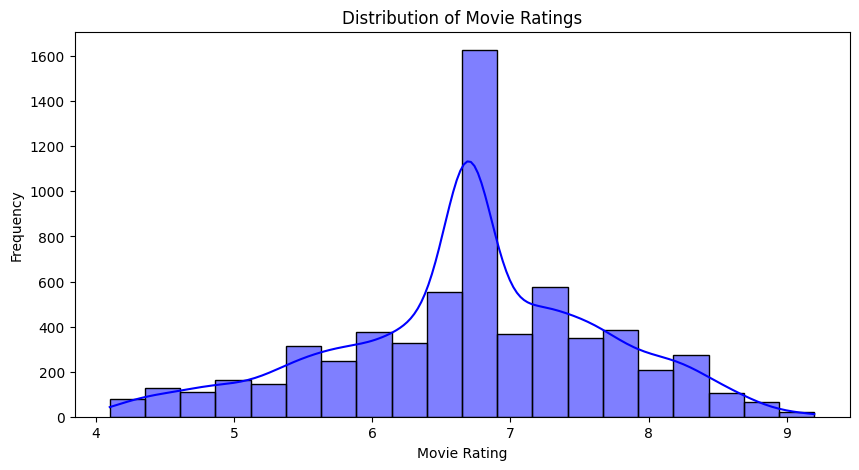

🎬 Director with most movies: jay karas (16 movies)
⭐ Star with most movies: johnny yong bosch (19 movies)


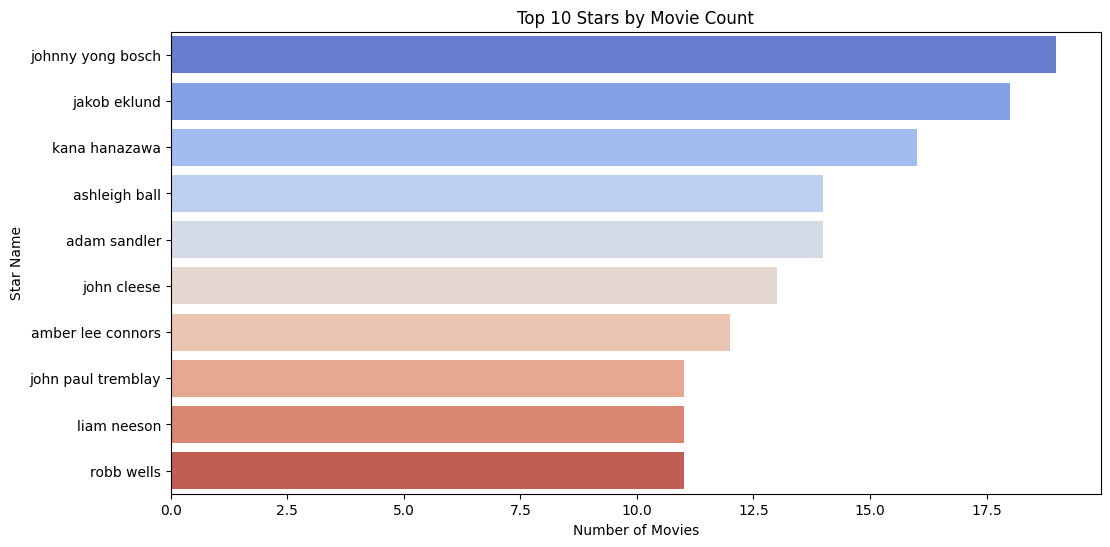

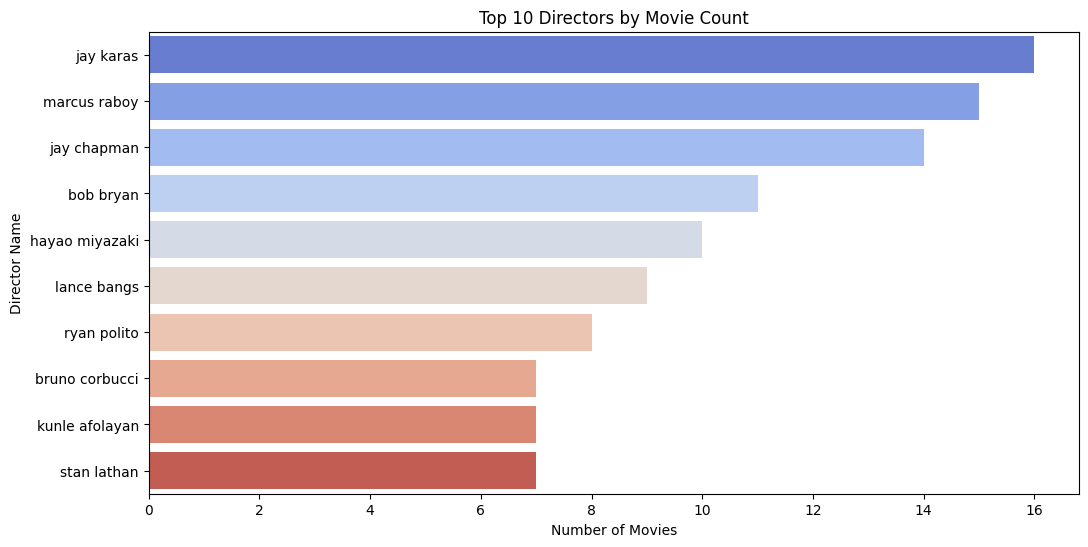

count    4149.000000
mean     2016.906966
std         3.059128
min      2007.000000
25%      2015.000000
50%      2017.000000
75%      2019.000000
max      2023.000000
Name: votes, dtype: float64


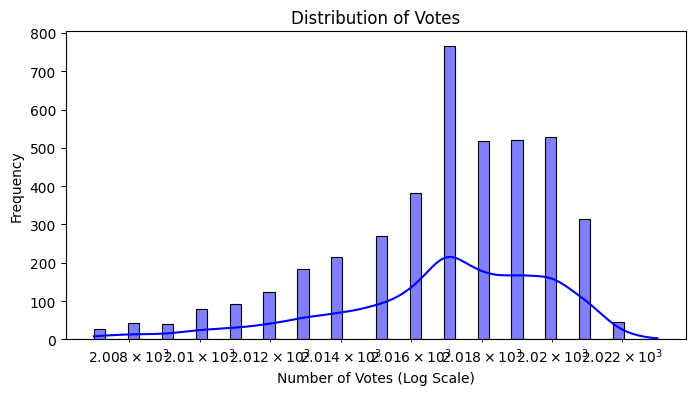

count    6422.000000
mean       77.132513
std        28.796663
min         6.000000
25%        60.000000
50%        84.000000
75%        94.000000
max       150.000000
Name: runtime, dtype: float64


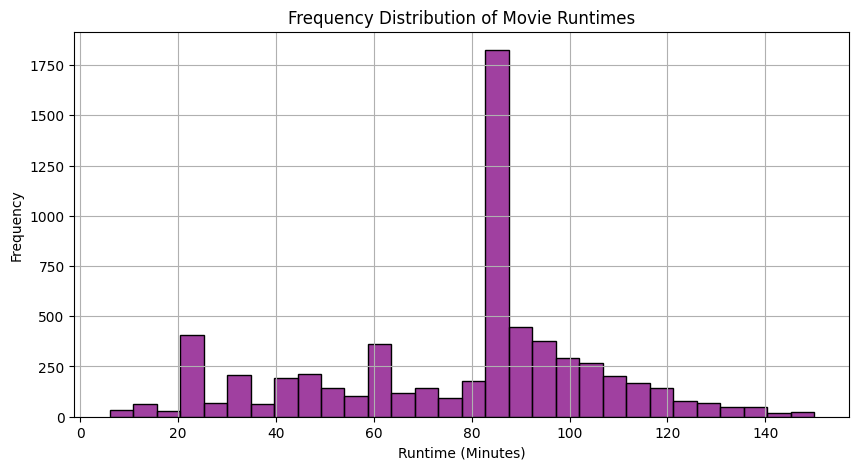

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import Counter
import numpy as np

# Load the dataset
movies = pd.read_csv("movies.csv")

# Convert column names to lowercase for consistency
movies.columns = movies.columns.str.lower()

# Standardize the 'movies' column (convert to lowercase, trim spaces, remove extra spaces)
movies['movies'] = movies['movies'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove duplicate movie entries based on the 'movies' column
movies.drop_duplicates(subset=['movies'], inplace=True)

# Handle missing values in 'genre' by replacing them with 'unknown'
movies.fillna({'genre': 'unknown'}, inplace=True)
movies['genre'] = movies['genre'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean 'one-line' descriptions (standardize text formatting)
movies['one-line'] = movies['one-line'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Ensure 'stars' column follows a standardized format
def add_missing_director(row):
    """ Ensures every entry in the 'stars' column includes both director and stars information. """
    if isinstance(row, str) and 'director:' in row.lower():
        if 'stars:' in row.lower():
            return row
        else:
            return row + (" stars: unknown" if '|' in row else "| stars: unknown")
    elif isinstance(row, str) and 'stars:' in row.lower():
        return "director: unknown| " + row
    else:
        return "director: unknown| stars: unknown"

movies['stars'] = movies['stars'].apply(add_missing_director)
movies['stars'] = movies['stars'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean the 'year' column (standardize formatting and remove invalid characters)
movies['year'] = movies['year'].str.replace('-', '–', regex=True)  # Replace hyphens
movies['year'] = movies['year'].str.replace(r'[^\d–]', '', regex=True)  # Remove non-numeric characters
movies['year'] = movies['year'].str.replace(r'–+', '–', regex=True)  # Remove multiple dashes
movies['year'] = movies['year'].str.replace(r'^–', '', regex=True)  # Remove leading dashes

# Fill missing years with 'unknown'
movies.fillna({'year': 'unknown'}, inplace=True)

# Handle missing values in 'rating' by replacing them with the median rating
median_rating = movies['rating'].median()
movies.fillna({'rating': median_rating}, inplace=True)

# Convert 'votes' to numeric (remove commas) and fill missing values with the median
movies['votes'] = movies['votes'].astype(str).str.replace(',', '', regex=True)
movies['votes'] = pd.to_numeric(movies['votes'], errors='coerce')
median_votes = movies['votes'].median()
movies.fillna({'votes': median_votes}, inplace=True)

# Erroneous reassignment (Possible Bug: this replaces 'votes' with 'year', fix needed)
movies['votes'] = pd.to_numeric(movies['year'], errors='coerce')

# Handle missing values in 'runtime' by replacing them with the median runtime
median_runtime = movies['runtime'].median()
movies.fillna({'runtime': median_runtime}, inplace=True)

# Check for missing values in 'gross' and drop the column if too many are missing
missing_percent = movies['gross'].isnull().mean() * 100
movies.drop(columns=['gross'], inplace=True)

# Box plot to visualize the distribution of 'votes' before outlier removal
plt.figure(figsize=(8, 4))
sns.boxplot(x=movies['votes'], color="red")
plt.xlabel("Votes")
plt.title("Box Plot of Votes")
plt.show()

def remove_outliers_iqr(df, column):
    """ Identifies and replaces outliers using the Interquartile Range (IQR) method. """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median value
    median_value = df[column].median()
    df.loc[df[column] < lower_bound, column] = median_value
    df.loc[df[column] > upper_bound, column] = median_value

# Apply outlier removal for key numerical features
remove_outliers_iqr(movies, 'votes')
remove_outliers_iqr(movies, 'runtime')
remove_outliers_iqr(movies, 'rating')

# Box plot after outlier removal
plt.figure(figsize=(8, 4))
sns.boxplot(x=movies['votes'], color="red")
plt.xlabel("Votes")
plt.title("Box Plot of Votes (Outliers Removed)")
plt.show()

# Extracting and analyzing unique genres
all_genres = movies['genre'].dropna().str.split(', ').explode()
unique_genres = all_genres.unique()

# Displaying the number of unique genres and listing them
print("Number of unique genres:", len(unique_genres))
print(unique_genres)

# Displaying the most and least frequent genres
print("\nTop 10 Most Frequent Genres:\n", all_genres.value_counts().head(10))
print("\nLeast Frequent Genres:\n", all_genres.value_counts().tail(10))

# Counting occurrences of each genre
genre_counts = all_genres.value_counts()
print("\nGenre Frequency Distribution:\n", genre_counts)

# Visualizing genre frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Frequency of each genre")
plt.show()

# Extracting start year from 'year' column
movies['start_year'] = movies['year'].str.extract(r'(\d{4})').astype(float)
print(movies['start_year'].describe())

# Counting movies released per year and visualizing
year_counts = movies['start_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=year_counts.index[50:], y=year_counts.values[50:], color='blue')
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Movies Released Per Year")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

# Analyzing the length of 'one-line' descriptions
movies['one-line_length'] = movies['one-line'].apply(len) 
movies['word_count'] = movies['one-line'].apply(lambda x: len(x.split())) 

# Displaying statistical summary
print(movies[['one-line_length', 'word_count']].describe())

# Analyzing ratings
print(movies['rating'].describe())

# Finding movies with minimum and maximum ratings
min_rating = movies['rating'].min()
min_rating_movies = movies[movies['rating'] == min_rating][['movies', 'rating']]
print("Movies with the Minimum Rating:")
print(min_rating_movies)

max_rating = movies['rating'].max()
max_rating_movies = movies[movies['rating'] == max_rating][['movies', 'rating']]
print("\nMovies with the Maximum Rating:")
print(max_rating_movies)

# Checking skewness in ratings
print("Skewness:", skew(movies['rating']))

# Visualizing rating distribution
plt.figure(figsize=(10, 5))
sns.histplot(movies['rating'], bins=20, kde=True, color='blue')  
plt.xlabel("Movie Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Ratings")
plt.show()

# Extracting director and star names from the 'stars' column
def extract_director(text):
    if "director:" in text:
        director = text.split("director:")[-1].split("|")[0].strip()
        return director if director.lower() != "unknown" else None
    return None

def extract_stars(text):
    if "stars:" in text:
        stars = text.split("stars:")[-1].strip()
        return None if stars.lower() == "unknown" else stars.split(', ')
    return None

movies['director_cleaned'] = movies['stars'].apply(extract_director)
movies['stars_cleaned'] = movies['stars'].apply(extract_stars)

# Expanding the dataset by exploding the stars list
movies_exploded = movies.explode('stars_cleaned')

# 🎬 Director Analysis
director_movies = movies.groupby('director_cleaned').size()
most_movies_director = director_movies.idxmax()
most_movies_count = director_movies.max()

# ⭐ Star Analysis
star_movies = movies_exploded.groupby('stars_cleaned').size()
most_movies_star = star_movies.idxmax()
most_movies_star_count = star_movies.max()

# Printing results
print(f"🎬 Director with most movies: {most_movies_director} ({most_movies_count} movies)")
print(f"⭐ Star with most movies: {most_movies_star} ({most_movies_star_count} movies)")

# 🎭 Get top 10 stars by movie count
top_stars_by_count = star_movies.sort_values(ascending=False).head(10)

# 🔥 Bar Plot - Top 10 Stars by Movie Count
plt.figure(figsize=(12, 6))
sns.barplot(x=top_stars_by_count.values, y=top_stars_by_count.index, hue=top_stars_by_count.index, palette="coolwarm", legend=False)
plt.xlabel("Number of Movies")
plt.ylabel("Star Name")
plt.title("Top 10 Stars by Movie Count")
plt.show()

# 🎬 Get top 10 directors by movie count
top_directors_by_count = director_movies.sort_values(ascending=False).head(10)

# 🔥 Bar Plot - Top 10 Directors by Movie Count
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors_by_count.values, y=top_directors_by_count.index, hue=top_directors_by_count.index, palette="coolwarm", legend=False)
plt.xlabel("Number of Movies")
plt.ylabel("Director Name")
plt.title("Top 10 Directors by Movie Count")
plt.show()

# Analyzing votes distribution
print(movies['votes'].describe())

# Histogram of votes (log scale for better visualization)
plt.figure(figsize=(8, 4))
sns.histplot(movies['votes'], bins=50, kde=True, color="blue")
plt.xscale("log")
plt.xlabel("Number of Votes (Log Scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Votes")
plt.show()

# Analyzing runtime distribution
print(movies['runtime'].describe())

# Histogram of movie runtimes
plt.figure(figsize=(10, 5))
sns.histplot(movies['runtime'], bins=30, color="purple")
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Movie Runtimes")
plt.grid(True)
plt.show()
